# 2019-10-03_fundamentallearning_pytorchCharRNN_predictNationality

see here https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
import requests
import os
import glob
import torch
import unicodedata
import string
import random
import time
import math

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Data in

### Data download

In [2]:
url = 'https://download.pytorch.org/tutorial/data.zip'
if not os.path.isfile('data/pytorch_tutorial/data.zip'):
    r = requests.get(url)
    with open('data/pytorch_tutorial/data.zip', 'wb') as f:
        f.write(r.content)

In [3]:
os.listdir('data/pytorch_tutorial/')

['fra-eng', 'data', 'fra-eng.zip', 'data.zip']

In [4]:
fnames = glob.glob('data/pytorch_tutorial/data/names/*.txt')
fnames

['data/pytorch_tutorial/data/names/Spanish.txt',
 'data/pytorch_tutorial/data/names/German.txt',
 'data/pytorch_tutorial/data/names/Polish.txt',
 'data/pytorch_tutorial/data/names/Russian.txt',
 'data/pytorch_tutorial/data/names/Chinese.txt',
 'data/pytorch_tutorial/data/names/Portuguese.txt',
 'data/pytorch_tutorial/data/names/Japanese.txt',
 'data/pytorch_tutorial/data/names/French.txt',
 'data/pytorch_tutorial/data/names/English.txt',
 'data/pytorch_tutorial/data/names/Korean.txt',
 'data/pytorch_tutorial/data/names/Irish.txt',
 'data/pytorch_tutorial/data/names/Arabic.txt',
 'data/pytorch_tutorial/data/names/Vietnamese.txt',
 'data/pytorch_tutorial/data/names/Dutch.txt',
 'data/pytorch_tutorial/data/names/Italian.txt',
 'data/pytorch_tutorial/data/names/Scottish.txt',
 'data/pytorch_tutorial/data/names/Czech.txt',
 'data/pytorch_tutorial/data/names/Greek.txt']

### Data Cleaning and organising

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def clean_names(name):
    return unicode_to_ascii(name.strip())
    

In [6]:
# dict matching category (language) to list of names
category_lines = {}
# list of all languages
all_categories = []
# number of categories
n_categories = 0
for fname in fnames:
    with open(fname, 'r') as f:
        category = os.path.basename(fname)[:-4]
        names = [clean_names(line) for line in f]
        all_categories.append(category)
        category_lines[category] = names
n_categories = len(all_categories)
print(all_categories, n_categories)

['Spanish', 'German', 'Polish', 'Russian', 'Chinese', 'Portuguese', 'Japanese', 'French', 'English', 'Korean', 'Irish', 'Arabic', 'Vietnamese', 'Dutch', 'Italian', 'Scottish', 'Czech', 'Greek'] 18


### Data to tensor

Need to code the words as one hot vectors of dimension [1,n_letters], the first dimension is the batch size (1)

thus each word needs to be a [word_length,1,n_letters] tensor of one hot vectors

In [7]:
def letter_to_tensor(l):
    v = torch.zeros(1,n_letters)
    v[0,all_letters.find(l)] = 1
    return v
def word_to_tensor(word):
    w = torch.zeros(len(word),1,n_letters)
    for i,l in enumerate(word):
        w[i,0,all_letters.find(l)] = 1
    return w

In [8]:
letter_to_tensor('a').shape

torch.Size([1, 57])

In [9]:
word_to_tensor('ab').shape

torch.Size([2, 1, 57])

## make the network

In [10]:
import torch.nn as nn 

class RNN(nn.Module):
    
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.combined_size = data_size + hidden_size
        self.hidden_size = hidden_size
        self.i2o = nn.Linear(self.combined_size,output_size)
        self.i2h = nn.Linear(self.combined_size,hidden_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x, last_hidden):
        combined_data = torch.cat((x, last_hidden), 1)
        output = self.i2o(combined_data)
        hidden = self.i2h(combined_data)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [11]:
n_hidden = 128
hidden = torch.zeros(1, n_hidden)
rnn = RNN(n_letters, n_hidden, n_categories)
output, next_hidden = rnn(letter_to_tensor('a'), hidden)

In [12]:
print(output.shape, next_hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])


In [13]:
def category_from_output(out):
    top_n, top_i = out.topk(1)
    index = top_i[0].item()
    score = top_n[0].item()
    category = all_categories[index]
    return category, index, score

In [14]:
category_from_output(output)

('Italian', 14, -2.7616825103759766)

In [15]:
def random_choice(l):
    return l[random.randint(0,len(l)-1)]

def random_example():
    category = random_choice(all_categories)
    word = random_choice(category_lines[category])
    cat_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    word_tensor = word_to_tensor(word)
    return category, word, cat_tensor, word_tensor 
    

In [16]:
for i in range(10):
    cat,word,cat_t,word_t = random_example()
    print(cat,word,cat_t.size(),word_t.size())

German Gerst torch.Size([1]) torch.Size([5, 1, 57])
Chinese Pei torch.Size([1]) torch.Size([3, 1, 57])
Polish Szwarc torch.Size([1]) torch.Size([6, 1, 57])
Arabic Botros torch.Size([1]) torch.Size([6, 1, 57])
English Osman torch.Size([1]) torch.Size([5, 1, 57])
Korean Jang torch.Size([1]) torch.Size([4, 1, 57])
Czech Netsch torch.Size([1]) torch.Size([6, 1, 57])
Irish Ciardha torch.Size([1]) torch.Size([7, 1, 57])
Chinese Guang torch.Size([1]) torch.Size([5, 1, 57])
Chinese Qiu torch.Size([1]) torch.Size([3, 1, 57])


In [17]:
criterion = nn.NLLLoss()

In [18]:
lr=0.005
def train(cat_t,word_t):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(word_t.size()[0]):
        output, hidden = rnn(word_t[i],hidden)
    loss = criterion(output, cat_t)
    
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-lr,p.grad.data)
    return output, loss.item()

def time_since(start):
    now = time.time()
    dt = now - start
    mins = int(dt/60)
    return f'{mins:>02}:{dt - mins*60:>05.2f}(m:s)'

In [19]:
def evaluate(word_t):
    hidden = rnn.init_hidden()
    for i in range(word_t.size()[0]):
        output, hidden = rnn(word_t[i],hidden)
    return output

    

In [20]:
def evaluate_confusion(rnn, n_samples = 1000):
    confusion = torch.zeros(n_categories, n_categories)
    for i in range(n_samples):
        cat, word, cat_t, word_t = random_example()
        guess_cat, guess_index, _ = category_from_output(evaluate(word_t))
        confusion[all_categories.index(cat),guess_index] += 1

        # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    return confusion

In [21]:
def plot_confusion(confusion):
    # Set up plot
    fig = plt.figure(facecolor='white',figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)
    # ax.xticks(np.arange(len(all_categories),all_categories))
    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

In [22]:
cat,word,cat_t,word_t = random_example()

train(cat_t,word_t)

(tensor([[-2.8743, -2.7666, -2.9014, -2.9262, -2.9261, -2.8735, -2.8145, -2.8428,
          -2.7725, -2.9031, -2.9050, -2.9562, -2.8853, -3.0320, -2.9225, -3.0179,
          -2.8440, -2.9051]], grad_fn=<LogSoftmaxBackward>), 2.926138162612915)

In [23]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [26]:
def train_steps(rnn, n_iters = 1000, eval_every = 50):
    losses = []
    confusions = []
    start = time.time()
    for i in range(n_iters):
        cat,word,cat_t,word_t = random_example()
        output, loss = train(cat_t,word_t)
        losses.append(loss)

        if (i+1)%eval_every==0 or i ==0:
            confusions.append(evaluate_confusion(rnn))
            av_loss = sum(losses[-eval_every:])/eval_every
            print(f'iter = {i+1:<6} training time = {time_since(start)} %done = {i/n_iters*100:<5.0f}% loss = {av_loss:<10.4f}')
    return losses, confusions

In [28]:
losses, confusions = train_steps(rnn,n_iters=10000,eval_every=1000)

iter = 1      training time = 00:00.93(m:s) %done = 0    % loss = 0.0025    
iter = 1000   training time = 00:04.07(m:s) %done = 10   % loss = 2.4711    
iter = 2000   training time = 00:07.45(m:s) %done = 20   % loss = 2.3801    
iter = 3000   training time = 00:10.76(m:s) %done = 30   % loss = 2.3560    
iter = 4000   training time = 00:13.89(m:s) %done = 40   % loss = 2.2744    
iter = 5000   training time = 00:17.17(m:s) %done = 50   % loss = 2.2234    
iter = 6000   training time = 00:20.54(m:s) %done = 60   % loss = 2.1442    
iter = 7000   training time = 00:23.68(m:s) %done = 70   % loss = 2.1361    
iter = 8000   training time = 00:27.07(m:s) %done = 80   % loss = 2.0977    
iter = 9000   training time = 00:30.21(m:s) %done = 90   % loss = 2.0064    
iter = 10000  training time = 00:33.32(m:s) %done = 100  % loss = 1.9975    


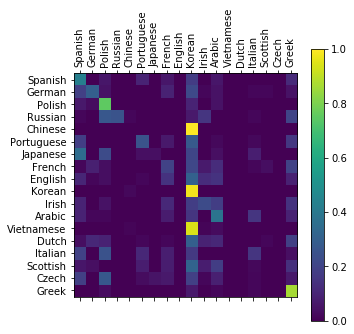

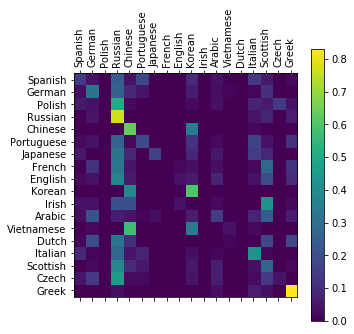

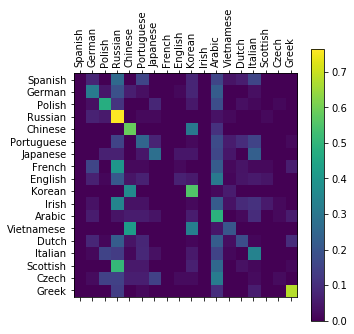

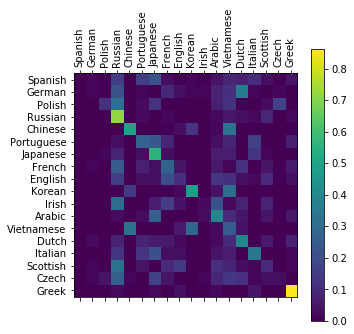

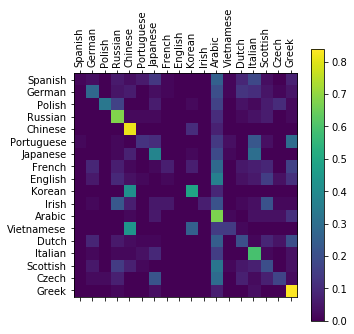

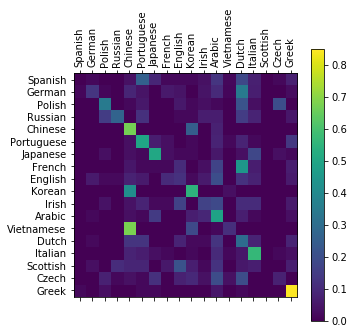

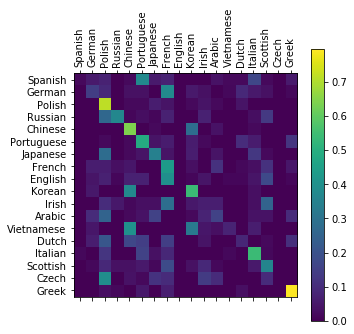

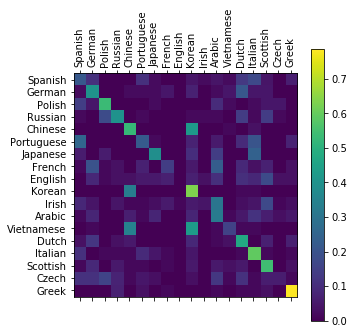

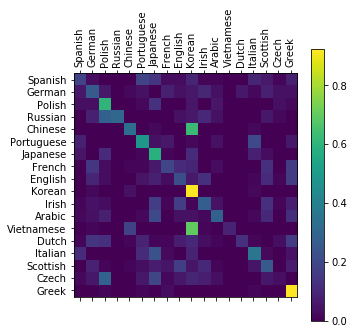

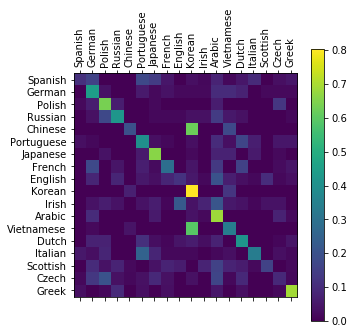

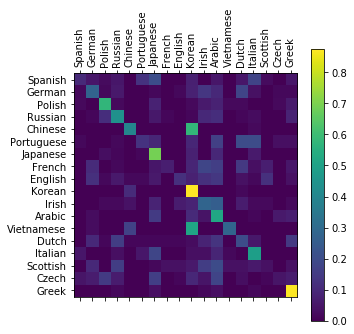

In [29]:
for c in confusions:
    plot_confusion(c)

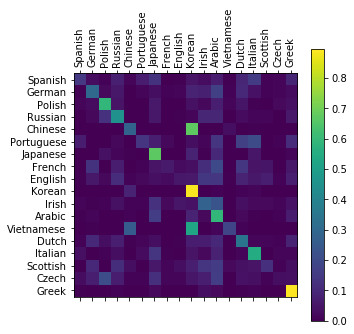

In [30]:
plot_confusion(evaluate_confusion(rnn,n_samples=10000))

TODO:

- test gpu vs cpu training time when not running batches
    - on 10k iters, gpu takes 27s, and cpu takes 21.
- Add an evaluate function (like train but with no gradients)
- Add an accuracy check function
- do a confusion matrix
Done

- run on batches? see https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e